In [5]:
import pandas as pd
import numpy as np
import nltk
from HanTa import HanoverTagger as ht
import string
from tqdm.auto import tqdm
import top2vec
import pickle
import mgzip
from nltk.tokenize import sent_tokenize

tqdm.pandas()

# Experiment on the ZEIT dataset for articles
## Tokenize, remove punctuation & lower casing
First, the original scraped text file is loaded (note: I use gzip compression due to the big size of the files). I then get the column names of all 'comment' columns and use this to tokenize and clean all columns. The resulting tokenized & cleaned dataframe is saved with the ending '_preprocessed'.

In [144]:
# load csv of file to process
zeit1 = pd.read_csv('../data/zeit_scraped.gzip', compression='gzip', low_memory=False)

In [18]:
comment_cols = [col for col in zeit.columns if 'Comment' in col]

In [19]:
zeit.drop(comment_cols, axis=1, inplace=True)

In [20]:
zeit.drop(['link', 'Tag0', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5'], axis=1, inplace=True)

In [21]:
zeit['text_token'] = zeit['combined_text'].map(nltk.word_tokenize)

In [22]:
def remove_punctuation(text):
    text_list = []
    for word in text:
        for punctuation in string.punctuation:
            word = word.replace(punctuation, '')
        if not word:
            continue
        text_list.append(word.lower())
    return text_list

In [23]:
zeit['text_token'] = zeit['text_token'].progress_apply(remove_punctuation)

  0%|          | 0/8668 [00:00<?, ?it/s]

## Stop word removal, lemmatization of comments & emotion lexicon
Following, stopwords without meaning ('der', 'wo', etc.) are removed from the comments. I edited the sourced stopwords list and removed any negations, since these contain emotions that I want to capture later in the workflow. Afterwards, the remaining tokenized words for each comment are lemmatized, i.e. reduced to their basic form. In order to do this I utilise the 'Hannover Tagger', which also provides part of speech information, although I do not use it (the main reason that I do not use the PoS information is that the utilised German emotion and sentiment lexical use different PoS abbreviations, resulting in no matches). The resulting output is saved as a new file with the ending '_lemma'.

In [24]:
stopwords = open('../resources/german_stopwords-master/german_stopwords_plain.txt').read().splitlines()

In [25]:
def stop_word_removal(x):
    return list([str(w) for w in x if not w in stopwords])

In [26]:
zeit['text_token'] = zeit['text_token'].apply(stop_word_removal)

In [15]:
zeit['text_token'] = zeit['text_token'].apply(' '.join)

In [167]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [35]:
def tagger_custom(input):
    tmp_list = []
    for word in input:
        tmp_list.append(tagger.analyze(word)[0].lower())
    return tmp_list

In [37]:
zeit['text_token'] = zeit['text_token'].progress_apply(tagger_custom)

  0%|          | 0/8668 [00:00<?, ?it/s]

In [39]:
zeit['combined_text_joined'] = zeit['text_token'].apply(' '.join)

In [ ]:
with mgzip.open('../data/zeit_articles.mgzip', 'wb') as handle:
    pickle.dump(zeit, handle)

## Topic modeling with top2vec for articles
Creates unique topics for each article, as feature for the comment prediction. Has to be run with speed='learn' / 'deep-learn' properly.

In [9]:
with mgzip.open('../data/zeit_articles.mgzip', 'rb') as handle:
    zeit = pickle.load(handle)

In [3]:
model = top2vec.Top2Vec(list(zeit['combined_text_joined']), speed="learn", ngram_vocab=False, embedding_model='universal-sentence-encoder-multilingual')

2022-05-20 16:24:59,099 - top2vec - INFO - Pre-processing documents for training
/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-05-20 16:25:07,526 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2022-05-20 16:25:07.611480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-20 16:25:07.611772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci 

Metal device set to: Apple M1


2022-05-20 16:25:08.978471: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-20 16:25:08.979954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 16:25:09,004 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-05-20 16:25:09.120408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 16:29:02,674 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-05-20 16:29:27,977 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-05-20 16:29:28,177 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
# save model in order to save on computation time
model.save('../models/topic2vec_learn.t2v')

In [70]:
# load precomputed model; args used: min_count=50, speed="fast-learn", ngram_vocab=False, workers=18, embedding_model='universal-sentence-encoder-multilingual'
model = top2vec.Top2Vec.load('../models/topic2vec_learn.t2v')

Look at unreduced topics, found by unsupervised machine learning

In [71]:
num_of_topics = model.get_num_topics(reduced=False)

In [72]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=False)

In [73]:
topic_words, word_scores, topic_nums = model.get_topics(num_of_topics, reduced=False)

In [74]:
topic_nums, topic_score, topics_words, word_scores = model.get_documents_topics(list(zeit.index), reduced=False, num_topics=2)

Reduce the models to 10, according to the percentage size of the topics

In [76]:
topic_percent = pd.DataFrame()
topic_percent['sizes'] = topic_sizes
topic_percent['percent'] = topic_percent['sizes']/sum(topic_percent['sizes'])
topic_percent['percent']

0     0.089640
1     0.051454
2     0.050877
3     0.038533
4     0.030688
        ...   
66    0.003461
67    0.003115
68    0.003115
69    0.002769
70    0.002653
Name: percent, Length: 71, dtype: float64

In [126]:
model.hierarchical_topic_reduction(7)

[[69,
  14,
  31,
  66,
  37,
  53,
  54,
  17,
  10,
  41,
  3,
  57,
  49,
  1,
  23,
  52,
  51,
  61,
  29,
  5,
  65,
  27,
  43,
  35,
  33,
  4],
 [59, 15, 47, 45, 68, 70, 13, 40, 20, 28, 63, 58, 19, 36, 7],
 [6, 22, 42, 50, 48, 56, 9],
 [67, 2, 12, 26, 44, 34],
 [0],
 [38, 64, 11, 25, 32, 46, 60, 8],
 [55, 62, 21, 16, 24, 30, 39, 18]]

In [127]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=False)
topics_words, words_scores, topics_nums = model.get_topics(reduced=True)
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(list(zeit.index), reduced=True, num_topics=2)

In [128]:
topic_nums

array([[1, 5],
       [0, 5],
       [3, 0],
       ...,
       [2, 0],
       [2, 6],
       [0, 5]])

In [129]:
topics_words

array([['epidemisch', 'epidemie', 'bundesregierung', 'bundesland',
        'bundestag', 'pandemiepolitik', 'epidemiologen', 'risikopatient',
        'neuinfiziert', 'influenza', 'impfen', 'immunisieren',
        'gesundheitsamt', 'bundeskanzlerin', 'populisten',
        'epidemiologe', 'immunisierung', 'bundesebene', 'bundesrat',
        'kranke', 'bundesinstitut', 'krankheit', 'diseases', 'heinsberg',
        'bundesprasident', 'bundesweit', 'grippe', 'krank',
        'pharmakonzern', 'nurnberg', 'immunologe', 'bundeswehr',
        'mehrheit', 'grippeimpfung', 'schuloffnung', 'bundesstaat',
        'virologe', 'minderheit', 'schwerkranken', 'populistisch',
        'infectious', 'besserung', 'bevolkerung', 'bundeskanzler',
        'pharmafirmen', 'immunzell', 'bekampfung', 'augsburg',
        'bundesburger', 'grippewelle'],
       ['heinsberg', 'bayern', 'augsburg', 'bundestag', 'dusseldorfer',
        'nurnberg', 'bundesland', 'rausgehen', 'wurzburg', 'spahn',
        'munchen', 'neui

Looking at wordclouds of reduced topics to find topic name, conculsion

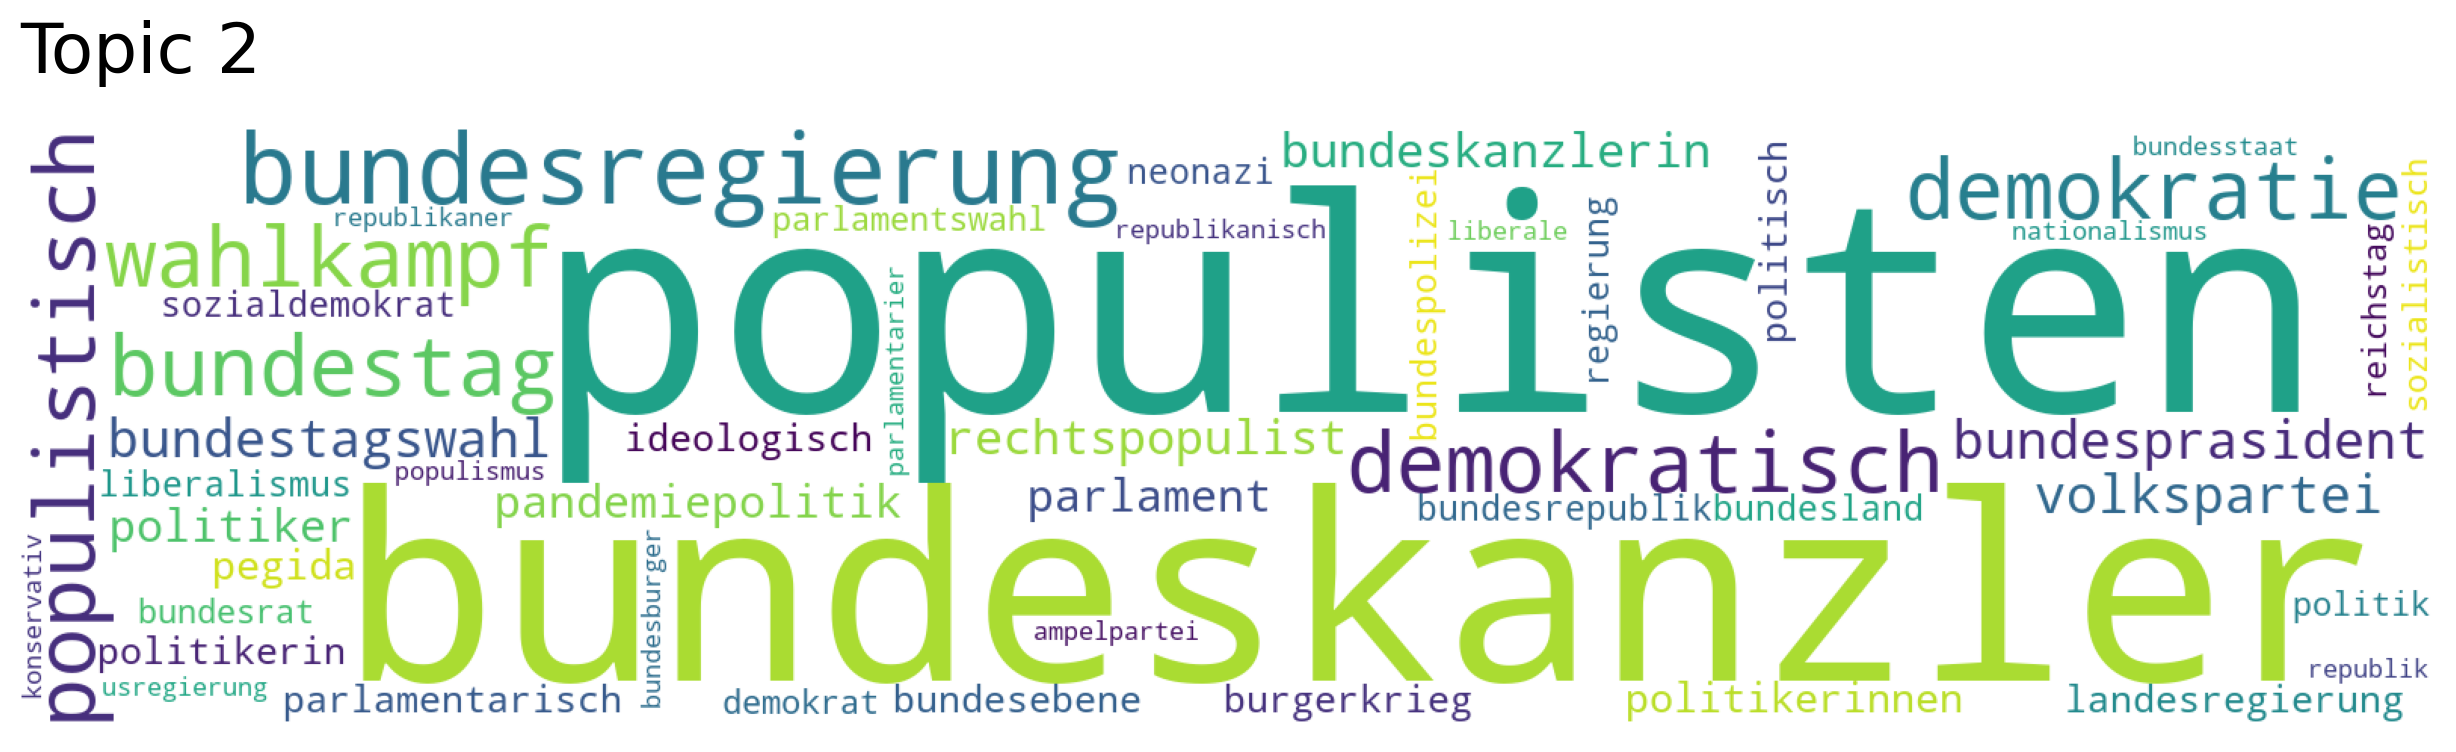

In [91]:
model.generate_topic_wordcloud(2, background_color='white', reduced=True)

In [92]:
label_dict = {0: 'Pandemiepolitik', 1: 'Regionalpolitik', 2: 'Populismus', 3: 'Infektionen', 4: 'Impfung', 5: 'Migration', 6: 'Finanzkrise'}

In [118]:
reduced_labels = model.doc_top_reduced

In [119]:
reduced_labels = np.vectorize(label_dict.get)(reduced_labels)

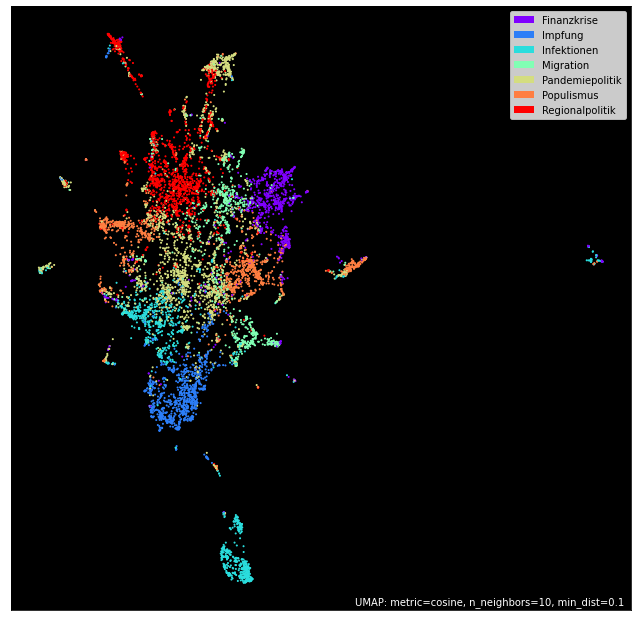

In [121]:
import umap.plot
umap_args_model = {"n_neighbors": 10, "n_components": 2, "metric": "cosine", 'min_dist':0.10, 'spread':1}
umap_model = umap.UMAP(**umap_args_model).fit(model.document_vectors)
umap_fig2 = umap.plot.points(umap_model, labels = reduced_labels, theme='fire')

In [130]:
from bertopic import BERTopic

topic_model = BERTopic(language="multilingual")

In [131]:
topics, probs = topic_model.fit_transform(zeit['combined_text_joined'])

In [133]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,3773,-1_nicht_als_sagen_aus
1,0,509,0_impfstoff_impfung_impfen_dosis
2,1,422,1_prozent_milliarde_euro_wirtschaft
3,2,283,2_rki_melden_zahlen_todesfall
4,3,235,3_schule_schüler_lehrer_kind
...,...,...,...
82,86,12,86_mauer_sexuell_hinrichtung_täter
88,87,11,87_tönnies_dorgerloh_könig_online
89,88,10,88_assange_huemer_mieter_merkel
90,89,10,89_grad_jahrhundert_atmosphäre_klimawandel


In [134]:
topic_model.get_topic(0)

[('impfstoff', 0.030119636375165654),
 ('impfung', 0.020607478881490632),
 ('impfen', 0.01477036823023199),
 ('dosis', 0.014193546644020567),
 ('astrazeneca', 0.011285548102264698),
 ('biontech', 0.010531693140153908),
 ('million', 0.009381344039546333),
 ('ema', 0.008392630860410744),
 ('mensch', 0.008145687930383042),
 ('können', 0.007817375557898552)]

## Feature engineering

### Average sentence length

In [10]:
def avg_sent_len(input):
    sent_tokenize_list = sent_tokenize(input)
    return sum(len(x.split()) for x in sent_tokenize_list) / len(sent_tokenize_list)

In [12]:
zeit['avg_length'] = zeit['text'].apply(avg_sent_len)

### Presence of adjectives

In [17]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [23]:
def adj_count(input):
    keywords = ['ADJA', 'ADJD', 'ADV']
    count_adj = 0
    count_total = 0
    for word in input:
        count_total += 1
        tag = tagger.analyze(word)[1]
        if tag in keywords:
            count_adj += 1
    if count_total == 0:
        count_total = 1
    return count_adj, count_adj/count_total

In [27]:
zeit['adjectives'] = zeit['combined_text'].progress_apply(adj_count)

  0%|          | 0/8668 [00:00<?, ?it/s]

In [30]:
zeit[['count_adj', 'percent_adj']] = pd.DataFrame(zeit['adjectives'].tolist(), index=zeit.index)

In [32]:
zeit.drop('adjectives', axis=1, inplace=True)

In [33]:
zeit

,title,date,combined_text,combined_text_joined,text,avg_length,count_adj,percent_adj
0,"Handel: ""Viele brauchen ja eigentlich nichts m...",2021-11-30 06:07:00,"[zeit, herr, weber, herr, rauschen, herr, grei...",zeit herr weber herr rauschen herr greiner wei...,"ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...",12.931818,178,0.207459
1,DGB-Index Gute Arbeit: An den Kosten im Homeof...,2021-11-30 05:50:00,"[gut, arbeitsbedingung, deutschland, beginn, c...",gut arbeitsbedingung deutschland beginn corona...,Wie gut sind die Arbeitsbedingungen in Deutsch...,17.200000,80,0.202020
2,Coronavirus: RKI registriert erstmals wieder l...,2021-11-30 04:23:00,"[zahl, neuinfektion, pro, 100000, einwohner, w...",zahl neuinfektion pro 100000 einwohner woche a...,Die Zahl der Neuinfektionen pro 100.000 \nEinw...,14.638298,81,0.200495
3,Bund-Länder-Runde: Kanzleramtschef fordert Cor...,2021-11-30 02:01:00,"[bundländerschalte, coronakrise, pochen, gesch...",bundländerschalte coronakrise pochen geschäfts...,Vor der Bund-Länder-Schalte zur Corona-Krise\n...,17.703704,49,0.185606
4,Corona-Impfung für Kinder: Gesundheitsminister...,2021-11-29 19:22:00,"[gesundheitsministerin, minister, land, wollen...",gesundheitsministerin minister land wollen cor...,Die Gesundheitsministerinnen und -minister der...,17.000000,37,0.182266
...,...,...,...,...,...,...,...,...
8663,Malaysia: Squash-WM der Männer abgesagt,2021-11-30 12:11:00,"[squashweltmeisterschaft, mann, malaysia, absa...",squashweltmeisterschaft mann malaysia absagen ...,Die Squashweltmeisterschaft der Männer in Mala...,14.266667,20,0.149254
8664,Corona-Impfstoff: Moderna rechnet mit geringer...,2021-11-30 11:52:00,"[chef, uspharmakonzerns, moderna, stéphane, ba...",chef uspharmakonzerns moderna stéphane bancel ...,"Der Chef des US-Pharmakonzerns Moderna, Stépha...",18.588235,30,0.181818
8665,Bundesverfassungsgericht: Corona-Ausgangsbesch...,2021-11-30 10:42:00,"[april, 2021, beschlossen, bundesnotbremse, nä...",april 2021 beschlossen bundesnotbremse nächtli...,Die im April 2021\nbeschlossene Bundesnotbrems...,16.073171,70,0.193370
8666,Koalitionsvertrag: Ein Dokument voller schille...,2021-11-30 07:27:00,"[schon, ungewöhnlich, unverständlich, ja, unve...",schon ungewöhnlich unverständlich ja unverzeih...,"Es\nist schon eine ungewöhnliche, unverständli...",16.288462,110,0.233546


### Mention of scientist

In [34]:
def scientist_count(input):
    keywords = ['drosten', 'streeck', 'lauterbach', 'kekulé', 'schmidt-chanasit', 'wodarg']
    scientist = []
    for word in input:
        if word in keywords:
            scientist.append(word)
    return scientist

In [36]:
df_scientsts = zeit['combined_text'].progress_apply(scientist_count).str.join('|').str.get_dummies()

  0%|          | 0/8668 [00:00<?, ?it/s]

### Combine features into one dataframe

In [41]:
zeit = pd.concat([zeit, df_scientsts], axis=1)

In [43]:
zeit

,title,date,combined_text,combined_text_joined,text,avg_length,count_adj,percent_adj,drosten,kekulé,lauterbach,streeck,wodarg
0,"Handel: ""Viele brauchen ja eigentlich nichts m...",2021-11-30 06:07:00,"[zeit, herr, weber, herr, rauschen, herr, grei...",zeit herr weber herr rauschen herr greiner wei...,"ZEIT: Herr Weber, Herr Rauschen, Herr Greiner,...",12.931818,178,0.207459,0,0,0,0,0
1,DGB-Index Gute Arbeit: An den Kosten im Homeof...,2021-11-30 05:50:00,"[gut, arbeitsbedingung, deutschland, beginn, c...",gut arbeitsbedingung deutschland beginn corona...,Wie gut sind die Arbeitsbedingungen in Deutsch...,17.200000,80,0.202020,0,0,0,0,0
2,Coronavirus: RKI registriert erstmals wieder l...,2021-11-30 04:23:00,"[zahl, neuinfektion, pro, 100000, einwohner, w...",zahl neuinfektion pro 100000 einwohner woche a...,Die Zahl der Neuinfektionen pro 100.000 \nEinw...,14.638298,81,0.200495,0,0,0,0,0
3,Bund-Länder-Runde: Kanzleramtschef fordert Cor...,2021-11-30 02:01:00,"[bundländerschalte, coronakrise, pochen, gesch...",bundländerschalte coronakrise pochen geschäfts...,Vor der Bund-Länder-Schalte zur Corona-Krise\n...,17.703704,49,0.185606,0,0,0,0,0
4,Corona-Impfung für Kinder: Gesundheitsminister...,2021-11-29 19:22:00,"[gesundheitsministerin, minister, land, wollen...",gesundheitsministerin minister land wollen cor...,Die Gesundheitsministerinnen und -minister der...,17.000000,37,0.182266,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8663,Malaysia: Squash-WM der Männer abgesagt,2021-11-30 12:11:00,"[squashweltmeisterschaft, mann, malaysia, absa...",squashweltmeisterschaft mann malaysia absagen ...,Die Squashweltmeisterschaft der Männer in Mala...,14.266667,20,0.149254,0,0,0,0,0
8664,Corona-Impfstoff: Moderna rechnet mit geringer...,2021-11-30 11:52:00,"[chef, uspharmakonzerns, moderna, stéphane, ba...",chef uspharmakonzerns moderna stéphane bancel ...,"Der Chef des US-Pharmakonzerns Moderna, Stépha...",18.588235,30,0.181818,0,0,0,0,0
8665,Bundesverfassungsgericht: Corona-Ausgangsbesch...,2021-11-30 10:42:00,"[april, 2021, beschlossen, bundesnotbremse, nä...",april 2021 beschlossen bundesnotbremse nächtli...,Die im April 2021\nbeschlossene Bundesnotbrems...,16.073171,70,0.193370,0,0,0,0,0
8666,Koalitionsvertrag: Ein Dokument voller schille...,2021-11-30 07:27:00,"[schon, ungewöhnlich, unverständlich, ja, unve...",schon ungewöhnlich unverständlich ja unverzeih...,"Es\nist schon eine ungewöhnliche, unverständli...",16.288462,110,0.233546,0,0,0,0,0


In [45]:
# load command
with mgzip.open('../data/zeit_predict.mgzip', 'rb') as handle:
    zeit_predict = pickle.load(handle)

,title,vote,ssentia,count
0,Bundestag: Falsche Gewinner,negative,neutral,262
1,Bundeswirtschaftsminister: Peter Altmaier wil...,negative,neutral,102
2,"Corona-Impfungen: ""Ich war zur richtigen Zeit...",positive,neutral,50
3,Corona-Lockerungen: Bayern und Hessen stellen...,negative,neutral,86
4,Corona-Neuinfektionen: RKI schätzt die Lage w...,positive,neutral,43
...,...,...,...,...
8255,Übergewicht bei Kindern: Dick durch die Pandemie,negative,neutral,12
8256,Übergewicht: Warum adipöse Menschen schwerer a...,negative,neutral,54
8257,Übergriffe im Bundestag: Chef der Innenministe...,negative,neutral,253
8258,Überlastete Intensivstationen: Erste Covid-Int...,neutral,neutral,22


## Construct prediction dataset

In [50]:
pd.merge(zeit_predict,zeit, on='title', how='inner')

,title,vote,ssentia,count,date,combined_text,combined_text_joined,text,avg_length,count_adj,percent_adj,drosten,kekulé,lauterbach,streeck,wodarg
0,Bundestag: Falsche Gewinner,negative,neutral,262,2021-10-26 11:08:00,"[dienstag, neu, bundestag, erstmals, politikwi...",dienstag neu bundestag erstmals politikwissens...,An diesem Dienstag kommt der neue Bundestag er...,17.465909,157,0.207947,0,0,0,0,0
1,Bundeswirtschaftsminister: Peter Altmaier wil...,negative,neutral,102,2020-03-08 08:54:00,"[bundeswirtschaftsministerpeter, altmaier, cor...",bundeswirtschaftsministerpeter altmaier corona...,BundeswirtschaftsministerPeter Altmaier\nwill ...,22.375000,34,0.187845,0,0,0,0,0
2,"Corona-Impfungen: ""Ich war zur richtigen Zeit...",positive,neutral,50,2021-04-25 18:57:00,"[aufklärungsgespräch, stich, oberarm, schließl...",aufklärungsgespräch stich oberarm schließlich ...,"Ein Aufklärungsgespräch, der Stich in den Ober...",18.280000,49,0.217778,0,0,0,0,0
3,Corona-Lockerungen: Bayern und Hessen stellen...,negative,neutral,86,2021-04-27 17:51:00,"[vollständig, geimpft, bayern, mittwoch, negat...",vollständig geimpft bayern mittwoch negativ co...,Vollständig Geimpfte werden in Bayern ab Mittw...,13.900000,29,0.195946,0,0,0,0,0
4,Corona-Neuinfektionen: RKI schätzt die Lage w...,positive,neutral,43,2020-12-11 12:05:00,"[coronalage, deutschland, einschätzung, robert...",coronalage deutschland einschätzung robert koc...,Die Corona-Lage in Deutschland ist nach Einsch...,13.333333,28,0.166667,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8358,Übergewicht bei Kindern: Dick durch die Pandemie,negative,neutral,12,2021-11-17 05:39:00,"[jörg, dötsch, direktor, kinderklinik, uniklin...",jörg dötsch direktor kinderklinik uniklinik kö...,"Jörg Dötsch, Direktor der Kinderklinik an der ...",17.518519,63,0.253012,0,0,0,0,0
8359,Übergewicht: Warum adipöse Menschen schwerer a...,negative,neutral,54,2020-08-18 10:51:00,"[olive, stiel, apfel, birne, –, geben, verschi...",olive stiel apfel birne – geben verschieden bi...,"Olive am Stiel, der Apfel oder eine Birne – es...",16.594203,122,0.195513,0,0,0,0,0
8360,Übergriffe im Bundestag: Chef der Innenministe...,negative,neutral,253,2020-11-21 09:00:00,"[störaktion, gast, afdfraktion, bundestag, sch...",störaktion gast afdfraktion bundestag schließe...,Nach den Störaktionen von Gästen der AfD-Frakt...,18.421053,27,0.144385,0,0,0,0,0
8361,Überlastete Intensivstationen: Erste Covid-Int...,neutral,neutral,22,2021-11-26 12:18:00,"[deutschland, erster, covid19patienten, intens...",deutschland erster covid19patienten intensivst...,In Deutschland sind die ersten Covid-19-Patien...,14.473684,18,0.110429,0,0,0,0,0
